## Kaggle Digit Dataset

## Imports

In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from datetime import datetime
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
import itertools
from keras.utils.np_utils import to_categorical
import io
#from keras.datasets import mnist

In [15]:
import os
print(os.listdir('./data'))

['Manipulatable.csv', 'Manipulated.csv', 'test.csv', 'test.csv.zip', 'testManipulation.csv', 'train.csv', 'train.csv.zip']


## Load Data

In [16]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
#sub = pd.read_csv('../input/sample_submission.csv')
print("Data are Ready!!")
print(f"Training data size is {train.shape}\nTesting data size is {test.shape}")

Data are Ready!!
Training data size is (42000, 785)
Testing data size is (28000, 784)


## Data Preprocessing

In [17]:
X = train.drop(['label'], 1).values
y = train['label'].values
X = X / 255.0
X = X.reshape(-1,28,28,1)
y = to_categorical(y)

print(f"Label size {y.shape}")

C:\Users\henri\AppData\Local\Temp\ipykernel_37624\3741675627.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = train.drop(['label'], 1).values


Label size (42000, 10)


In [18]:
# Split the train and the validation set for the fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

## Data Augmentation

In [19]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=128)
test_gen = datagen.flow(X_test, y_test, batch_size=128)

## Show Data

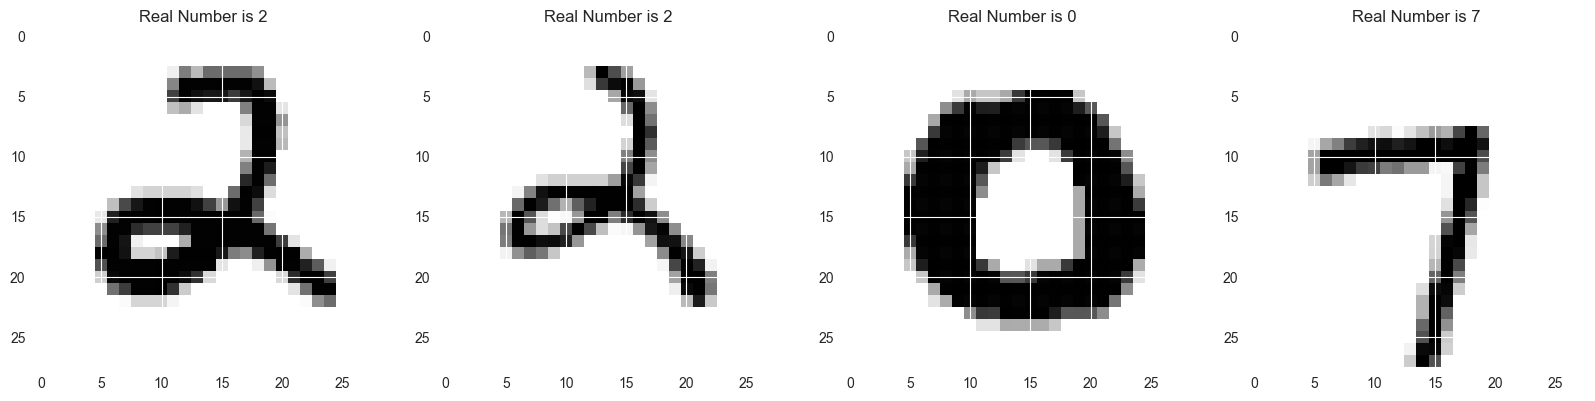

In [20]:
X_train__ = X_train.reshape(X_train.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Real Number is {digit}");

## Model Building

In [21]:
from keras.layers import BatchNormalization

model=Sequential()

model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512,activation="relu"))

model.add(Dense(10,activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         1

In [21]:
epochs = 100
batch_size = 128
train_steps = X_train.shape[0] // batch_size
valid_steps = X_test.shape[0] // batch_size

es = keras.callbacks.EarlyStopping(
        monitor="val_accuracy", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max",
        restore_best_weights=True,
     )

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

## TensorBoard

In [22]:
classes=[0,1,2,3,4,5,6,7,8,9]

def log_confusion_matrix(epoch, logs):
  y_pred = model.predict(X_test) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]
  Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
  Y_test = np.argmax(y_test, 1) # Decode labels
  con_mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

  con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)

  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

  buf = io.BytesIO()
  plt.savefig(buf, format='png')

  plt.close(figure)
  buf.seek(0)
  image = tf.image.decode_png(buf.getvalue(), channels=4)

  image = tf.expand_dims(image, 0)

  # Log the confusion matrix as an image summary.
  with file_writer_cm.as_default():
    tf.summary.image("Confusion Matrix", image, step=epoch)

In [23]:
# Create log directory
logdir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir = logdir, histogram_freq = 1)
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

#python -m tensorboard.main --logdir=logs/image

## Run Model

In [35]:
# Fit the model
history = model.fit(train_gen,
                    epochs = epochs,
                    steps_per_epoch = train_steps,
                    validation_data = test_gen,
                    validation_steps = valid_steps,
                    callbacks=[es, rp, tensorboard_callback,cm_callback])

Epoch 1/100
295/295 [==============================] - 71s 239ms/step - loss: 0.1540 - accuracy: 0.9520 - val_loss: 1.2919 - val_accuracy: 0.4810 - lr: 0.0010
Epoch 2/100
295/295 [==============================] - 64s 215ms/step - loss: 0.0672 - accuracy: 0.9791 - val_loss: 0.0615 - val_accuracy: 0.9817 - lr: 0.0010
Epoch 3/100
295/295 [==============================] - 70s 239ms/step - loss: 0.0515 - accuracy: 0.9840 - val_loss: 0.0564 - val_accuracy: 0.9856 - lr: 0.0010
Epoch 4/100
295/295 [==============================] - 71s 242ms/step - loss: 0.0402 - accuracy: 0.9873 - val_loss: 0.0523 - val_accuracy: 0.9861 - lr: 0.0010
Epoch 5/100
295/295 [==============================] - 74s 252ms/step - loss: 0.0378 - accuracy: 0.9891 - val_loss: 0.0608 - val_accuracy: 0.9836 - lr: 0.0010
Epoch 6/100
295/295 [==============================] - 69s 232ms/step - loss: 0.0392 - accuracy: 0.9876 - val_loss: 0.0775 - val_accuracy: 0.9780 - lr: 0.0010
Epoch 7/100
295/295 [=========================

## Model Analyse

132/132 [==============================] - 2s 17ms/step


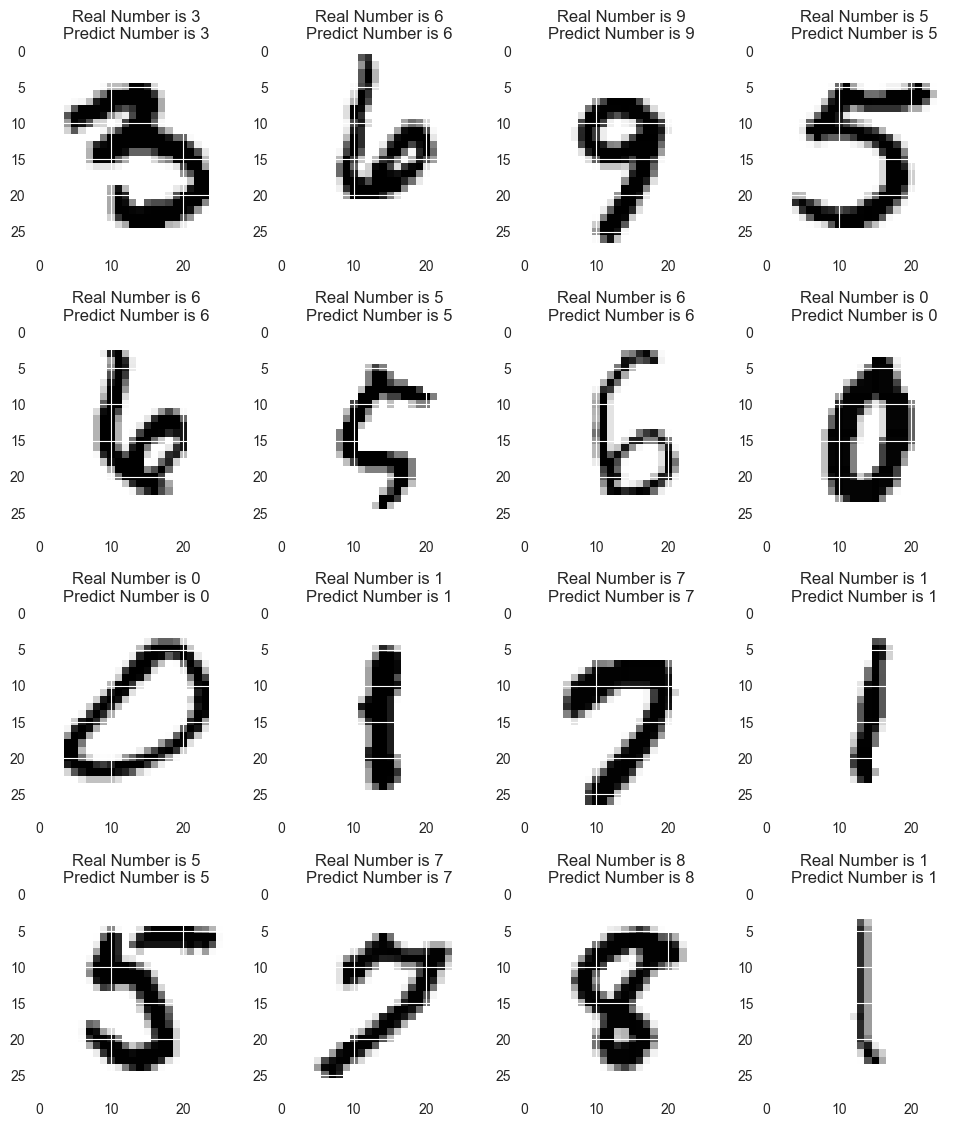

In [27]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

## Confusion Matrix

132/132 [==============================] - 2s 15ms/step


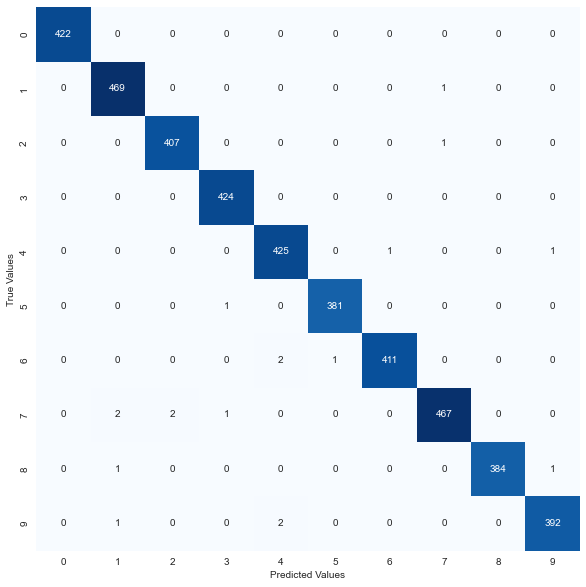

In [33]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(X_test) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

## Save / Load Model

In [61]:
# 1 - Save the full model
#model.save("./trained_models/best.h5")
#model.save("./trained_models/best_TFSaveFormat")
# 2 - Save the weights of the model
#model.save_weights("./trained_models/best_weights.h5")
# 3 - Save the architecture of the model
# json_string = model.to_json()
# with open("./trained_models/best_model.h5", "w") as f:
#     f.write(json_string)

In [24]:
# 1 - Load the model
model = keras.models.load_model("./trained_models/best.h5")
# 2 - Load the weights of a model
#model.load_weights("./trained_models/best_weights.h5")
# 3 - Load the architecture of a model
# with open("./trained_models/best_model.h5","r") as f:
#     loaded_json_string = f.read()
# new_model = keras.models.model_from_json(loaded_json_string)


# Manipulated Digit Tests

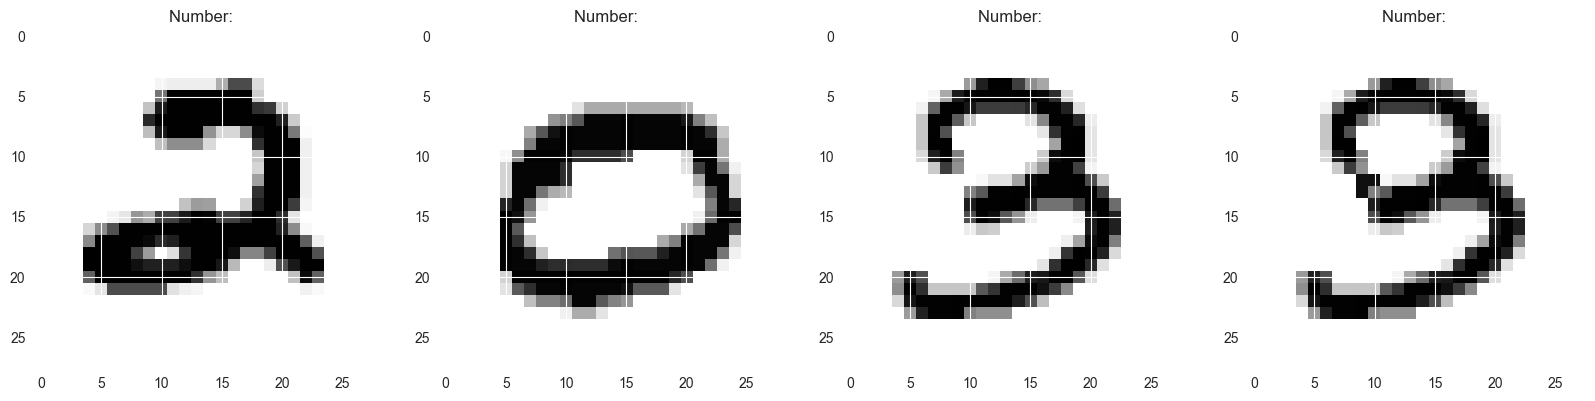

In [36]:
# Images without manipulation
testimages = pd.read_csv('./data/testManipulation.csv')
x_testimage = testimages.values

x = x_testimage / 255.0
x = x.reshape(-1,28,28,1)
#x = x_testimage.reshape(x_testimage.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(20, 20))
for i, ax in enumerate(axis.flat):
    ax.imshow(x[i], cmap='binary')

    ax.set(title = f"Number: ");

1/1 [==============================] - 0s 21ms/step


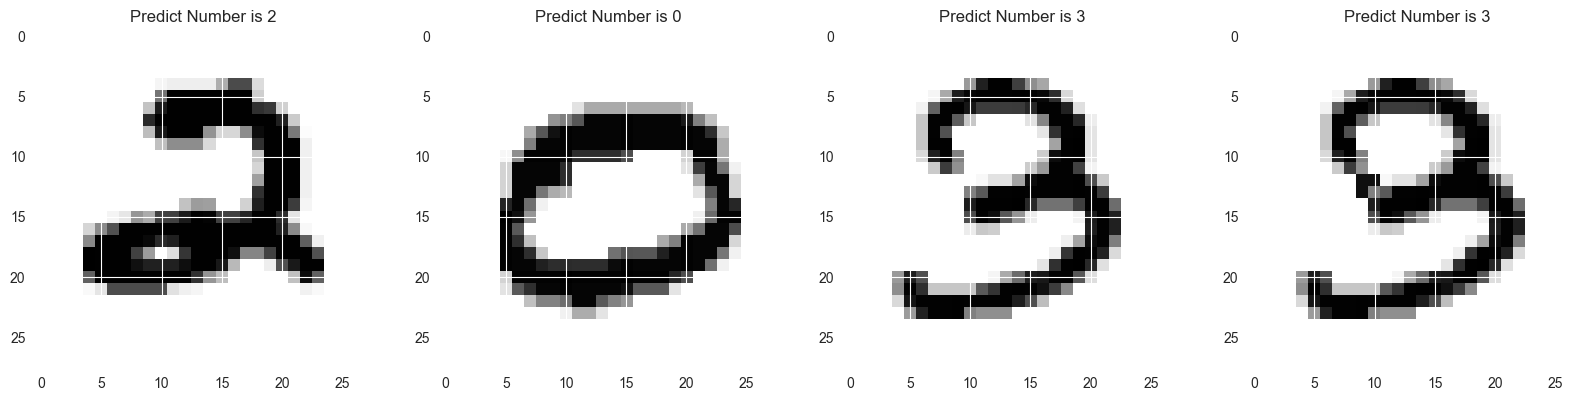

In [37]:
y_pred = model.predict(x)


fig, axis = plt.subplots(1, 4, figsize=(20, 20))
for i, ax in enumerate(axis.flat):
    ax.imshow(x[i], cmap='binary')
    ax.set(title = f"Predict Number is {y_pred[i].argmax()}")

C:\Users\henri\AppData\Local\Temp\ipykernel_14136\3899838368.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_testimage = testimages.drop(['label'], 1).values


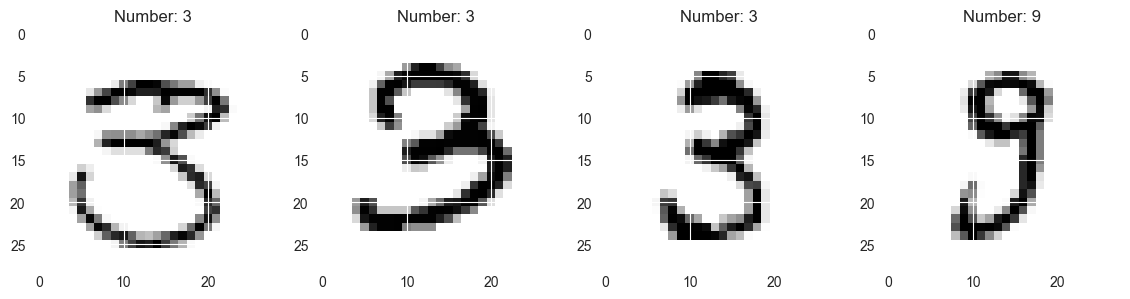

In [3]:
# Images without manipulation
testimages = pd.read_csv('./data/Manipulatable.csv')
x_testimage = testimages.drop(['label'], 1).values
y_testimage = testimages['label'].values
y_testimage = to_categorical(y_testimage)
xShow = x_testimage.reshape(x_testimage.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(14, 7))
for i, ax in enumerate(axis.flat):
    ax.grid(True)
    ax.imshow(xShow[i], cmap='binary')
    digit = y_testimage[i].argmax()
    ax.set(title = f"Number: {digit}");

In [11]:
# Images with manipulation
train = pd.read_csv('./data/Manipulated.csv')

X = train.drop(['label'], 1).values

y = train['label'].values
X = X / 255.0
X = X.reshape(-1,28,28,1)
y = to_categorical(y)

print(f"Label size {y.shape}")

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Label size (2, 5)


C:\Users\henri\AppData\Local\Temp\ipykernel_37624\3350597873.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = train.drop(['label'], 1).values


array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

1/1 [==============================] - 0s 117ms/step


IndexError: index 2 is out of bounds for axis 0 with size 2

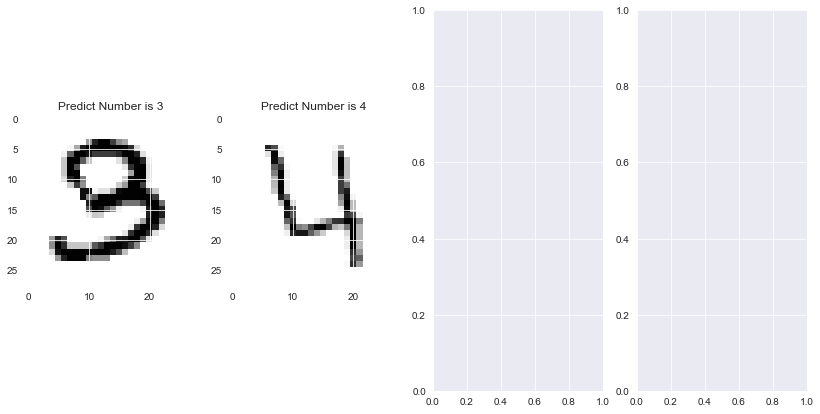

In [31]:
y_pred = model.predict(X)
X_test__ = X.reshape(X.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(14, 7))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Predict Number is {y_pred[i].argmax()}")